In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

import numpy as np
import random

# Task 1 (seq2seq RNN)

In [2]:
n_timesteps_in = 80 # length of input sequence
n_timesteps_out = 60 # length of output sequence

n_features_in = 1
n_features_out = 1

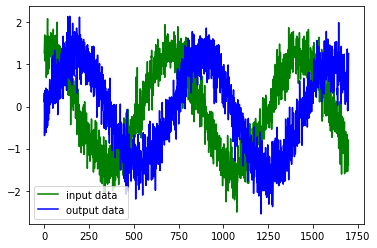

In [3]:
time_series_length = 1700
t = np.linspace(0, 5, time_series_length)

ts_output = np.sin(t) / 3 + 3 * np.sin(t*3) +  0.8 * np.random.standard_normal(size=time_series_length)
ts_input = np.cos(t) / 3 + 4 * np.cos(t*3) + 0.9 * np.random.standard_normal(size=time_series_length)

# normalize the data
ts_norm_input = (ts_input - np.mean(ts_input)) / np.std(ts_input)
ts_norm_output = (ts_output - np.mean(ts_output)) / np.std(ts_output)
plt.plot(ts_norm_input, 'green', label = 'input data')
plt.plot(ts_norm_output,'blue', label = 'output data')

plt.legend()

In [4]:
train_size = int(len(ts_input) * 0.8)
test_size = len(ts_input) - train_size

train_input, test_input = ts_norm_input[0:train_size], ts_norm_input[train_size:len(ts_input)]
train_output, test_output = ts_norm_output[0:train_size], ts_norm_output[train_size:len(ts_input)]

In [5]:
seq_len = max(n_timesteps_in, n_timesteps_out)
def create_dataset():
    # train data
    train_input_data, train_output_data = [], []
    for i in range(500):
        rand_ind_train = random.randint(0, len(train_input) - seq_len)
        input_seq = ts_norm_input[rand_ind_train:rand_ind_train+n_timesteps_in]
        output_seq = ts_norm_output[rand_ind_train:rand_ind_train+n_timesteps_out]
        train_input_data.append(input_seq)
        train_output_data.append(output_seq)
    # test data
    test_input_data, test_output_data = [], []
    for i in range(5):
        rand_ind_test = random.randint(0, len(test_input) - seq_len)
        input_seq = ts_norm_input[rand_ind_test:rand_ind_test+n_timesteps_in]
        output_seq = ts_norm_output[rand_ind_test:rand_ind_test+n_timesteps_out]
        test_input_data.append(input_seq)
        test_output_data.append(output_seq)
    return np.array(train_input_data), np.array(train_output_data), np.array(test_input_data), np.array(test_output_data)

In [6]:
train_input_data, train_output_data, test_input_data, test_output_data = create_dataset()

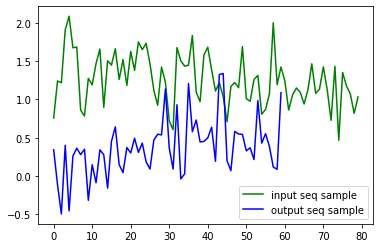

In [7]:
plt.plot(train_input_data[0], 'green', label = 'input seq sample')
plt.plot(train_output_data[0], 'blue', label = 'output seq sample')
plt.legend()

In [8]:
# reshape input to be [n_samples, n_time_steps, n_features]
train_input_data = np.reshape(train_input_data, (train_input_data.shape[0], n_timesteps_in, n_features_in))
train_output_data = np.reshape(train_output_data, (train_input_data.shape[0], n_timesteps_out, n_features_out))

test_input_data = np.reshape(test_input_data, (test_input_data.shape[0], n_timesteps_in, n_features_in))
test_output_data = np.reshape(test_output_data, (test_input_data.shape[0], n_timesteps_out, n_features_out))

# Build Model

In [9]:
from keras.layers import LSTM, Dense
from keras import Input, Model

n_units = 128

encoder_inputs = Input(shape=(n_timesteps_in, n_features_in))
encoder = LSTM(n_units, return_sequences=False, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

decoder_inputs = Input(shape=(n_timesteps_out, n_features_out))
decoder_lstm =  LSTM(n_units, return_sequences=True, return_state=True)

decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=[state_h, state_c])
decoder_dense = Dense(n_features_out, activation='linear')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [10]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 1)]      0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 60, 1)]      0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 128),        66560       ['input_1[0][0]']                
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                              

In [11]:
model.compile(optimizer='adam', loss='mse')

In [12]:
decoder_inputs = np.zeros(train_output_data.shape)

my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=5)]

model.fit([train_input_data, decoder_inputs], train_output_data,
          epochs=100, batch_size=64, validation_split=0.2, callbacks = my_callbacks, verbose=2)

Epoch 1/100
7/7 - 8s - loss: 0.9985 - val_loss: 1.0096 - 8s/epoch - 1s/step
Epoch 2/100
7/7 - 1s - loss: 0.9391 - val_loss: 0.9898 - 1s/epoch - 190ms/step
Epoch 3/100
7/7 - 1s - loss: 0.9159 - val_loss: 1.0121 - 1s/epoch - 181ms/step
Epoch 4/100
7/7 - 1s - loss: 0.9342 - val_loss: 0.9715 - 1s/epoch - 188ms/step
Epoch 5/100
7/7 - 1s - loss: 0.8888 - val_loss: 0.8358 - 1s/epoch - 195ms/step
Epoch 6/100
7/7 - 1s - loss: 0.6662 - val_loss: 0.5678 - 1s/epoch - 186ms/step
Epoch 7/100
7/7 - 1s - loss: 0.6178 - val_loss: 0.5553 - 1s/epoch - 186ms/step
Epoch 8/100
7/7 - 1s - loss: 0.6320 - val_loss: 0.5146 - 1s/epoch - 186ms/step
Epoch 9/100
7/7 - 1s - loss: 0.6428 - val_loss: 0.5425 - 1s/epoch - 171ms/step
Epoch 10/100
7/7 - 1s - loss: 0.6505 - val_loss: 0.5339 - 1s/epoch - 207ms/step
Epoch 11/100
7/7 - 1s - loss: 0.6227 - val_loss: 0.5050 - 1s/epoch - 204ms/step
Epoch 12/100
7/7 - 2s - loss: 0.6298 - val_loss: 0.5609 - 2s/epoch - 262ms/step
Epoch 13/100
7/7 - 2s - loss: 0.5411 - val_loss: 0.5

In [13]:
decoder_inputs = np.zeros(test_output_data.shape)
y_pred = model.predict([test_input_data, decoder_inputs])

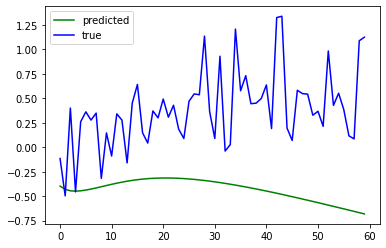

In [14]:
plt.plot(y_pred[0], 'green', label = 'predicted')
plt.plot(test_output_data[0], 'blue', label = 'true')

plt.legend()

## TASK 2 (GAN -  Fashion_mnist)

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers

import matplotlib.pyplot as plt
import numpy as np

np.random.seed(1000)

In [16]:
from keras.datasets import fashion_mnist

In [17]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [18]:
input_dim = 784
x_train = x_train.reshape(60000, input_dim)
print('input shape: ', x_train.shape[1])
x_train = (x_train.astype(np.float32) - 127.5) / 127.5  # normilization [-1, 1]

input shape:  784


# Build Model

In [19]:
optim = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [20]:
def build_discriminator():
    model =  keras.Sequential()
    model.add(layers.Dense(1024, input_dim=input_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(128))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optim)
    return model

In [21]:
latent_dim = 100

def build_generator():
    model =  keras.Sequential()

    model.add(layers.Dense(128, input_dim=latent_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Dense(input_dim, activation='tanh'))
    model.compile(loss='binary_crossentropy', optimizer=optim)
    return model

In [22]:
discriminator = build_discriminator()
generator = build_generator()

# Combined network
discriminator.trainable = False
gan_input = keras.Input(shape=(latent_dim,))
x = generator(gan_input)
gan_output = discriminator(x)
gan = keras.Model(inputs=gan_input, outputs=gan_output)
gan.compile(loss='binary_crossentropy', optimizer=optim)

In [23]:
def plot_generated_images(epoch, generator):
    num_of_images = 10
    noise = np.random.normal(0, 1, size=[num_of_images, latent_dim])
    generated_images=generator.predict(noise).reshape(num_of_images, 28, 28)
    plt.figure()
    for i in range(num_of_images):
        plt.subplot(1, 10, i+1)
        plt.imshow(generated_images[i], cmap = 'gray')
        plt.axis('off')
        plt.tight_layout()
    plt.show()

In [24]:
discrim_losses = []

def train_model(epochs, batch_size):
    num_batches = int(x_train.shape[0]/batch_size)
    for ep in range(epochs+1):
        for i in range(num_batches):
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

             # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 0.9  # (instead of 1.0) sort of trick in GAN training, so called label smoothing
            # Train discriminator
            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X, y_dis)
            discrim_losses.append(d_loss)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
        if ep % 20 == 0:
            print('epoch: ', ep)
            plot_generated_images(ep, generator)

epoch:  0


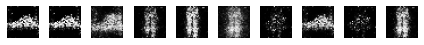

epoch:  20


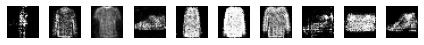

epoch:  40


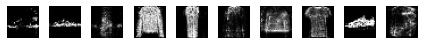

epoch:  60


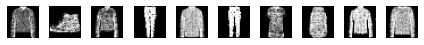

epoch:  80


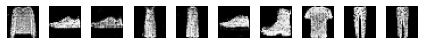

epoch:  100


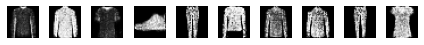

In [25]:
epochs = 100
batch_size = 128
train_model(epochs, batch_size)

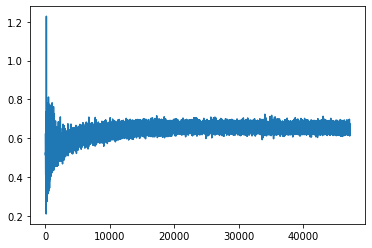

In [26]:
plt.plot(discrim_losses)

Останній результат рахувало 3 години))

# Дякую за увагу <3